# 1. Import Labraries

In [16]:
# basics
import random
import string
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px
from wordcloud import WordCloud

# Natural Language Processing
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('omw-1.4')
#nltk.download('averaged_perceptron_tagger')

# Machine Learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression   
from sklearn.naive_bayes import MultinomialNB   
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score, f1_score, recall_score

# 2.Import the Dataset

In [17]:
data = pd.read_csv("completeSpamAssassin.csv", encoding='utf-8')
data.head()
data.shape

(6046, 3)

# 3.Data Processing

In [18]:
data = data.rename(columns={'Body':'text'})
data = data.rename(columns={'Label':'label'})
data = data.drop(columns='Unnamed: 0')  #drop the useless column
data.head()

,text,label
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,##############################################...,1
4,I thought you might like these:\n1) Slim Down ...,1


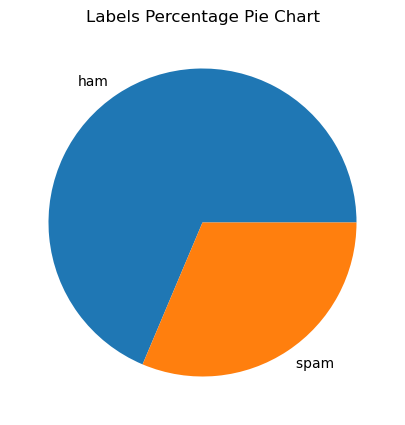

In [59]:
#output a pie chart and see the percentage of each label----->"ham"&"spam"
fig = plt.figure(figsize=(8, 5))
plt.title("Labels Percentage Pie Chart")
plt.pie(data['label'].value_counts(), labels = ['ham', 'spam ']) 
plt.show()

1)feature engineering

In [20]:
#the original type of text is float, we transforme it to string for the future operate
data['text'] = data['text'].astype(str) 

#add a new feature named "len" to the dataframe, means the length of each text.
data['len'] = data['text'].apply(len) 
data.head()

,text,label,len
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1,1111
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,753
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,610
3,##############################################...,1,2863
4,I thought you might like these:\n1) Slim Down ...,1,641


In [61]:
#set a histogram for checking the relationship between length and label

px.histogram(data, 'len', nbins= 182, color='label').update_layout(title_text='Relationship Between Length and Labels')

In [23]:
#add a new feature named "words", means the amount of words in each sentence(text)
# split strings into section is tokenization
data['words'] = data['text'].apply(lambda x: len(nltk.word_tokenize(x))) # to produce a list of words
# round(data['words'].describe(), 2)  #Rounding
data['words'].describe()
data.head()

,text,label,len,words
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1,1111,191
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,753,139
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,610,113
3,##############################################...,1,2863,690
4,I thought you might like these:\n1) Slim Down ...,1,641,108


In [62]:
#set a histogram which shows the words distribution
px.histogram(data, "words", nbins=44, color="label").update_layout(title_text='Relationship Between Words and Labels')

3)NLP

In [25]:
ps = nltk.stem.PorterStemmer()
def preproc(message):
    nostop = " ".join([word for word in message.split(' ') if word not in stopwords.words('english')])
    nopunct = ''.join([lett for lett in nostop if lett not in list(string.punctuation)])
    nocaps = [word.lower() for word in nopunct.split(' ')]
    norm = [ps.stem(word) for word in nocaps]
    return ' '.join(norm)
data['final_text'] = data['text'].apply(preproc)
data.head()

,text,label,len,words,final_text
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1,1111,191,\nsave 70 life insurance\nwhi spend more than ...
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,753,139,1 fight the risk cancer\nhttpwwwadclickwspcfmo...
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,610,113,1 fight the risk cancer\nhttpwwwadclickwspcfmo...
3,##############################################...,1,2863,690,\n ...
4,I thought you might like these:\n1) Slim Down ...,1,641,108,i thought might like these\n1 slim down guara...


# 4.Visualization

In [31]:
#visualize the data and try to output the most frequent word.
ham_text = " ".join(data[data.label == 1]['final_text'])
spam_text = " ".join(data[data['label'] == 0]['final_text'])
# print('------ham_text------\n' + ham_text)
# print('------spam_text------\n' + spam_text)

# calculate the frequency of each word.
ham_freq = nltk.FreqDist(nltk.word_tokenize(ham_text))
spam_freq = nltk.FreqDist(nltk.word_tokenize(spam_text))
print('------ham_freq------')
print(ham_freq)
print('------spam_freq------')
print(spam_freq)

------ham_freq------
<FreqDist with 28671 samples and 346273 outcomes>
------spam_freq------
<FreqDist with 66055 samples and 679541 outcomes>


1)visualize the frequency of these 2 data_freq:

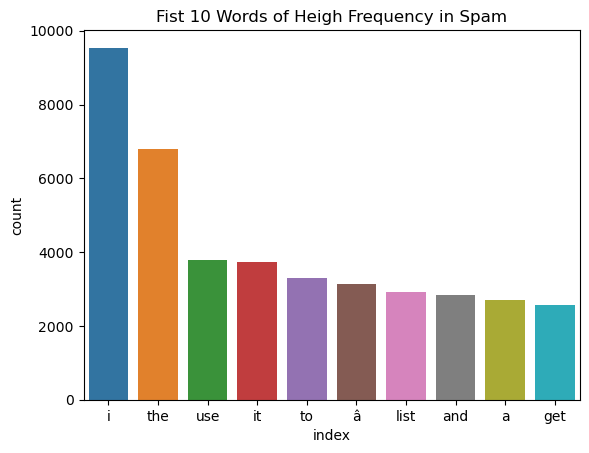

In [63]:
spam_freq_df = pd.DataFrame.from_dict(dict(spam_freq), 'index', columns=['count']).reset_index()
#output the fist 10 words of heigh frequency.
ax = sns.barplot(data = spam_freq_df.sort_values('count', ascending=False)[: 10], x = 'index', y = 'count')
ax.set_title("Fist 10 Words of Heigh Frequency in Spam")
plt.show()

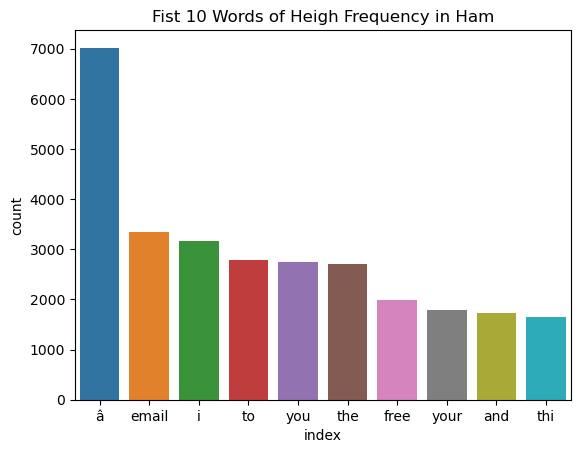

In [65]:
ham_freq_df = pd.DataFrame.from_dict(dict(ham_freq), 'index', columns=['count']).reset_index()
ax = sns.barplot(data = ham_freq_df.sort_values('count', ascending=False)[: 10], x = 'index', y = 'count')
ax.set_title('Fist 10 Words of Heigh Frequency in Ham')
plt.show()

# 5.TF-IDF --- Text Categorization

In [34]:
#TF-IDF
data.head()

,text,label,len,words,final_text
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1,1111,191,\nsave 70 life insurance\nwhi spend more than ...
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,753,139,1 fight the risk cancer\nhttpwwwadclickwspcfmo...
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,610,113,1 fight the risk cancer\nhttpwwwadclickwspcfmo...
3,##############################################...,1,2863,690,\n ...
4,I thought you might like these:\n1) Slim Down ...,1,641,108,i thought might like these\n1 slim down guara...


In [35]:
#set a TF-IDF matrix
tfidf = TfidfVectorizer(max_features = 3000)
x = tfidf.fit_transform(data['final_text']).toarray()
print(x)
print(data.label)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0       1
1       1
2       1
3       1
4       1
       ..
6041    0
6042    0
6043    0
6044    0
6045    0
Name: label, Length: 6046, dtype: int64


In [41]:
# pd.DataFrame(x)
y = data.label
# pd.DataFrame(y)

# 6.Machine Learning

In [42]:
#split the dataset into train and test data set
#use 30% for testing and 70% for training.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 100)

classify and predict by using logistic regression model and naive bayes model

In [43]:
lr = LogisticRegression(solver='liblinear', penalty='l1')
mnb = MultinomialNB()  # multi nomial naives bayes: feature matrix represents the frequencies

train our model with train set and do some predictions


In [50]:
# firstly, using lr
lr.fit(x_train, y_train)
y_pred_lr = lr.predict(x_test)
test_acc_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
print(f'Test ACC LR: {round(test_acc_lr, 3)}')
print(f'Precision LR: {round(precision_lr, 3)}')
print(f'F1_Score LR: {round(f1_lr, 3)}')
print(f'Recall LR: {round(recall_lr, 3)}')

Test ACC LR: 0.936
Precision LR: 0.879
F1_Score LR: 0.903
Recall LR: 0.928


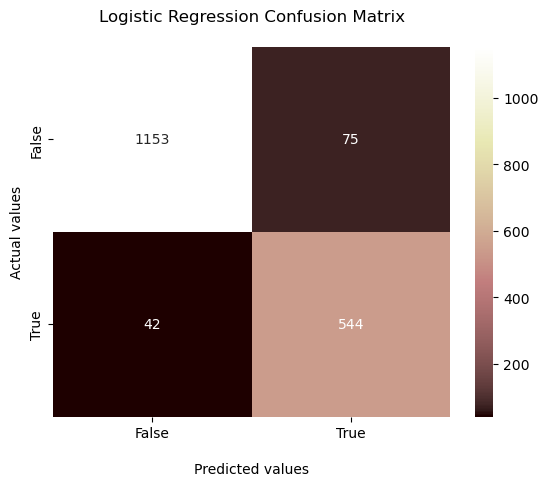

In [51]:
cf_matrix = confusion_matrix(y_test, y_pred_lr)
ax = sns.heatmap(cf_matrix, annot=True, cmap='pink', fmt='.5g')
ax.set_title('Logistic Regression Confusion Matrix\n')
ax.set_xlabel('\nPredicted values')
ax.set_ylabel('Actual values')
ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True'])
plt.show()

In [52]:
# secondly, using mnb
# multi nomial naives bayes: feature matrix represents the frequencies
mnb.fit(x_train, y_train)
y_pred_mnb = mnb.predict(x_test)
test_acc_mnb = accuracy_score(y_test, y_pred_mnb)
precision_mnb = precision_score(y_test, y_pred_mnb)
f1_mnb = f1_score(y_test, y_pred_mnb)
recall_mnb = recall_score(y_test, y_pred_mnb)
print(f'Test ACC MNB: {round(test_acc_mnb, 3)}')
print(f'Precision MNB: {round(precision_mnb, 3)}')
print(f'F1_Score MNB: {round(f1_mnb, 3)}')
print(f'Recall MNB: {round(recall_mnb, 3)}')

Test ACC MNB: 0.95
Precision MNB: 0.887
F1_Score MNB: 0.926
Recall MNB: 0.968


[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

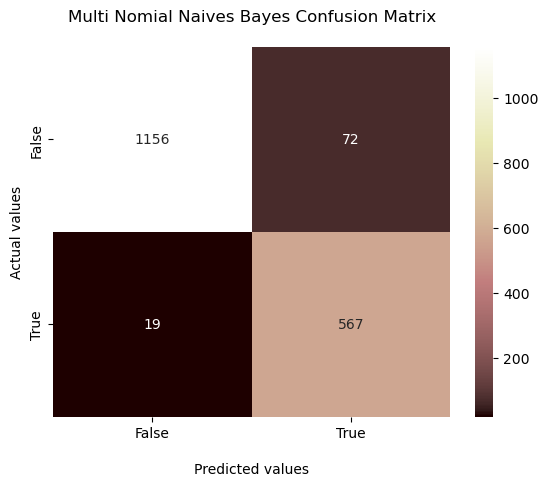

In [56]:
cf_matrix = confusion_matrix(y_test, y_pred_mnb)
ax = sns.heatmap(cf_matrix, annot=True, cmap='pink', fmt='.5g')
ax.set_title('Multi Nomial Naives Bayes Confusion Matrix\n')
ax.set_xlabel('\nPredicted values')
ax.set_ylabel('Actual values')
ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True'])